# EDA and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

DATA_PATH = "./data"
sections = ['environment', 'business', 'film', 'culture', 'education']

In [2]:
dfs = [pd.read_csv(f"{DATA_PATH}/{section}_news.csv") for section in sections]
df = pd.concat(dfs)

## Exploratory data analysis

In [3]:
df = df.reset_index(drop=True)
df

,Content,Section
0,A Victorian woman is facing almost 300 animal...,environment
1,Fish populations will continue to be over-expl...,environment
2,The Covid-19 vaccinations captured the world’s...,environment
3,New international rules to tackle the “wild we...,environment
4,The mother of Ella Kissi-Debrah has called on ...,environment
...,...,...
2749,More than 250 former pupils at Westminster Sch...,education
2750,"The chief inspector of schools, Amanda Spielma...",education
2751,Teaching unions and school leaders are to hold...,education
2752,Schools will prioritise pupils’ emotional and ...,education


In [4]:
df.describe()

,Content,Section
count,2754,2754
unique,2711,5
top,In the first episode of Netflix’s latest hit s...,film
freq,2,599


In [5]:
df[df.duplicated(keep=False)].sort_values(by=['Content']).head(10)

,Content,Section
2160,A question is posed in the group show Poet Sla...,culture
1988,A question is posed in the group show Poet Sla...,culture
2026,A stoush has erupted between the publisher of ...,culture
2180,A stoush has erupted between the publisher of ...,culture
2008,"Alicia Keys, I have a bone to pick with you. F...",culture
2136,"Alicia Keys, I have a bone to pick with you. F...",culture
2134,Aspiring film-makers take note: a love triangl...,culture
1999,Aspiring film-makers take note: a love triangl...,culture
2009,At the beginning of the pandemic Mae Martin’s ...,culture
2127,At the beginning of the pandemic Mae Martin’s ...,culture


In [6]:
df[df.duplicated()]['Section'].unique()

array(['culture'], dtype=object)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(2711, 2)

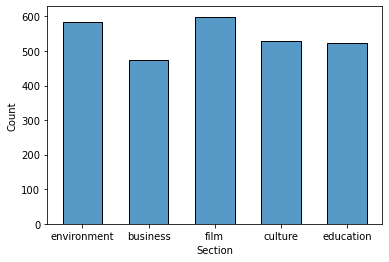

In [8]:
plt.figure()
ax = sns.histplot(data=df['Section'], shrink=.6)

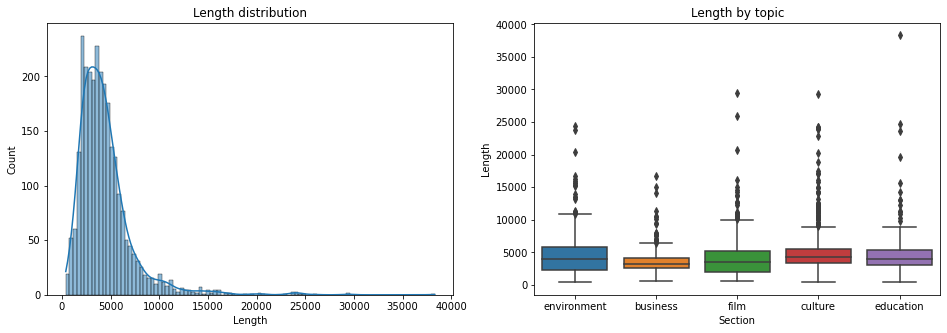

In [9]:
df['Length'] = df['Content'].str.len()

fig, axs = plt.subplots(1, 2, figsize=(16,5));
sns.histplot(df['Length'], kde=True, ax=axs[0]).set_title("Length distribution");
sns.boxplot(x=df['Section'], y=df['Length'], ax=axs[1]).set_title("Length by topic");

## Preprocessing text data

In [28]:
df.iloc[0,0]

' A Victorian woman is facing almost 300 animal cruelty charges after wildlife officers allegedly found the carcasses of 140 protected native birds, including 128 wedge-tailed eagles, at her property. The office of the conservation regulator said police, wildlife officers, and officials from the agriculture department searched the woman’s property in Violet Town in August after a number of dead wedge-tailed eagles were found in the area. She has been charged with 291 breaches of the Wildlife Act 1975 and the Prevention of Cruelty to Animals Act 1986, including offences relating to poisoning the birds of prey. The maximum penalty for killing native birds or being in possession of them without a licence carries hefty fines or penalties of up to two years in jail. The woman will face court in Benalla next year. The chief conservation regulator, Kate Gavens, said her office took matters like this “very seriously”. “Wedge-tailed eagles are Victoria’s largest bird of prey and an important pa

In [30]:
df['Content_1'] = df['Content'].str.lower()
df['Content_1'] = df['Content_1'].str.strip()
df.head()

,Content,Section,Length,Content_1
0,A Victorian woman is facing almost 300 animal...,environment,1593,a victorian woman is facing almost 300 animal ...
1,Fish populations will continue to be over-expl...,environment,4199,fish populations will continue to be over-expl...
2,The Covid-19 vaccinations captured the world’s...,environment,23818,the covid-19 vaccinations captured the world’s...
3,New international rules to tackle the “wild we...,environment,5458,new international rules to tackle the “wild we...
4,The mother of Ella Kissi-Debrah has called on ...,environment,3198,the mother of ella kissi-debrah has called on ...


In [12]:
nlp = spacy.load("en_core_web_sm")
nlp

In [31]:
txt0 = df['Content_1'].iloc[0]
txt0

'a victorian woman is facing almost 300 animal cruelty charges after wildlife officers allegedly found the carcasses of 140 protected native birds, including 128 wedge-tailed eagles, at her property. the office of the conservation regulator said police, wildlife officers, and officials from the agriculture department searched the woman’s property in violet town in august after a number of dead wedge-tailed eagles were found in the area. she has been charged with 291 breaches of the wildlife act 1975 and the prevention of cruelty to animals act 1986, including offences relating to poisoning the birds of prey. the maximum penalty for killing native birds or being in possession of them without a licence carries hefty fines or penalties of up to two years in jail. the woman will face court in benalla next year. the chief conservation regulator, kate gavens, said her office took matters like this “very seriously”. “wedge-tailed eagles are victoria’s largest bird of prey and an important par

In [32]:
for token in nlp(txt0):
    print(token.text, '--', token.is_stop, '--', token.is_punct)

a -- True -- False
victorian -- False -- False
woman -- False -- False
is -- True -- False
facing -- False -- False
almost -- True -- False
300 -- False -- False
animal -- False -- False
cruelty -- False -- False
charges -- False -- False
after -- True -- False
wildlife -- False -- False
officers -- False -- False
allegedly -- False -- False
found -- False -- False
the -- True -- False
carcasses -- False -- False
of -- True -- False
140 -- False -- False
protected -- False -- False
native -- False -- False
birds -- False -- False
, -- False -- True
including -- False -- False
128 -- False -- False
wedge -- False -- False
- -- False -- True
tailed -- False -- False
eagles -- False -- False
, -- False -- True
at -- True -- False
her -- True -- False
property -- False -- False
. -- False -- True
the -- True -- False
office -- False -- False
of -- True -- False
the -- True -- False
conservation -- False -- False
regulator -- False -- False
said -- False -- False
police -- False -- False
, 